## Лабораторная №2

## Распознавание MNIST на CNTK

Посмотрим, насколько хорошо у вас получится распознать с помощью CNTK уже известные нам рукописные цифры.

In [1]:
%matplotlib inline
import numpy as np
import cntk
from cntk import Trainer
from cntk.learners import sgd
from cntk.ops import *
from cntk.io import *
from cntk.layers import *
import pylab

In [2]:
import pickle
import os
if not os.path.exists('mnist.pkl'):
    !rm *.pkl
    #!wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
    !curl -O https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
    !gzip -d mnist.pkl.gz
        
with open('mnist.pkl', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle)

Мы получили объект `MNIST`, содержащий все необходимые данные. Проведем с ними небольшие преобразования:

  * Нормируем, чтобы яркость пискселей была в диапазоне $[0,1]$
  * Приведём labels к векторному виду с помощью функции $\mathrm{conv}: \mathbb{N} 	\to \mathbb{N}^{10}$, где $i\mapsto \left(\mathrm{eq}(i,j)
\right)_{j=0}^9$, и $\mathrm{eq}(i,j) = \begin{cases}
         1, & i=j \\
         0, & i\not=j
\end{cases}$

In [3]:
features = MNIST['Train']['Features'].astype(np.float32) / 256.0
labels = MNIST['Train']['Labels']

def conv(n):
    return np.array([ 1 if x==n else 0 for x in range(10)])

labels = np.array([ conv(x) for x in labels],dtype=np.float32)

In [4]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features,labels,test_size=0.2)

Описываем переменные, модель и ошибку

In [5]:
input_var = input_variable(784)
label_var = input_variable(10)

model = Sequential([
          Dense(100, init=glorot_uniform(),activation=relu),
          Dense(10, init=glorot_uniform(),activation=None)]);

# Подсказка: попробуйте использовать model = Sequential([....]) для комбинации слоёв!

z = model(input_var)

ce = cntk.cross_entropy_with_softmax(z, label_var)
pe = cntk.classification_error(z, label_var)


Описываем `learner` и `trainer`. Переменная `progress` будет хранить достигнутую точность на разных шагах обучения.

In [6]:
minibatch_size = 16

lr_per_minibatch = cntk.learning_rate_schedule(0.01, cntk.UnitType.minibatch)
pp = cntk.logging.ProgressPrinter()
    
learner = cntk.adagrad(z.parameters, lr = lr_per_minibatch)
trainer = cntk.Trainer(z, (ce, pe), [learner],[pp])

cntk.logging.log_number_of_parameters(z)
progress = []

Training 79510 parameters in 4 parameter tensors.


Начинаем обучение. Обратите внимание, что вы можете менять количество эпох и минибатчей в каждой эпохе. Можете запускать этот блок несколько раз, он будет дообучать модель и достраивать график.

In [7]:
for epoch in range(5):
    perm = np.random.permutation(len(labels_train))
    taccuracy = 0; tloss = 0; cnt = 0
    for i in range(0, len(labels_train), minibatch_size):
        max_n = min(i + minibatch_size, len(labels_train))
        x = features_train[perm[i:max_n]]
        t = labels_train[perm[i:max_n]]
        trainer.train_minibatch({input_var:x,label_var:t})
        tloss += trainer.previous_minibatch_loss_average*trainer.previous_minibatch_sample_count
        taccuracy += trainer.previous_minibatch_evaluation_average*trainer.previous_minibatch_sample_count
        cnt+=trainer.previous_minibatch_sample_count
        pp.update_with_trainer(trainer,with_metric=True)
    progress.append([tloss,taccuracy])
    pp.epoch_summary(with_metric=True)

Learning rate per minibatch: 0.01
Finished Epoch[1 of 300]: loss = 2.111695 * 33600, metric = 70.45% * 33600 6.014s (5587.2 samples/s);
Finished Epoch[2 of 300]: loss = 1.555223 * 33600, metric = 35.83% * 33600 3.891s (8635.6 samples/s);
Finished Epoch[3 of 300]: loss = 1.115473 * 33600, metric = 25.93% * 33600 3.985s (8432.5 samples/s);
Finished Epoch[4 of 300]: loss = 0.886217 * 33600, metric = 21.63% * 33600 3.922s (8566.8 samples/s);
Finished Epoch[5 of 300]: loss = 0.768103 * 33600, metric = 19.76% * 33600 3.969s (8465.7 samples/s);


Пробуем вычислить функцию потерь и ошибку на тестовой выборке

In [8]:
vloss = np.average(ce.eval({input_var:features_test,label_var:labels_test}))
verr = np.average(pe.eval({input_var:features_test,label_var:labels_test}))
print("Loss={}, Error={}".format(vloss,verr))

Loss=0.7369419932365417, Error=0.19452381134033203


[ 0.03636416  0.00393189  0.03222026  0.05035965  0.00364438  0.04899027
  0.01050529  0.76880586  0.0031894   0.04198894]


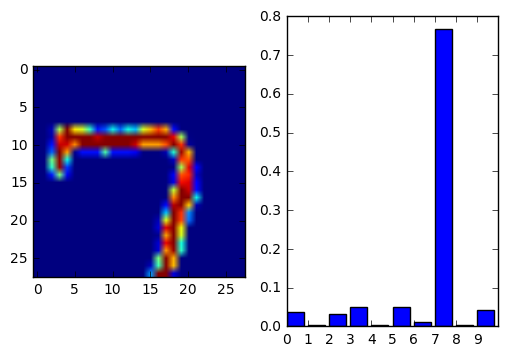

[ 0.00318078  0.01908099  0.29230791  0.00485116  0.21159892  0.02779148
  0.39023691  0.0202218   0.0149972   0.0157329 ]


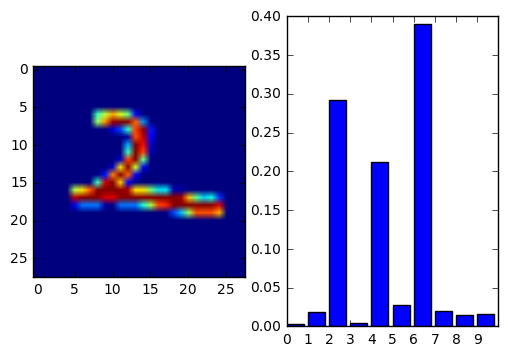

In [9]:
def plot(x):
    fig = pylab.figure()
    ax = fig.add_subplot(1,2,1)
    pylab.imshow(x.reshape(28,28))
    p = cntk.softmax(z)
    hist = p.eval({input_var:x})
    print(hist[0][0])
    ax = fig.add_subplot(1,2,2)
    pylab.bar(np.arange(10),hist[0][0])
    pylab.xticks(np.arange(10))
    pylab.show()
    
plot(features_test[0])
plot(features_test[13])

## Задание

1. Попробовать достичь минимальной величины ошибки на тестовых данных за счет изменения архитектуры сети
   - попробуйте многослойный персептрон
   - попробуйте разные функции активации
2. В процессе обучения строить training error и testing error и посмотреть, если ли переобучение
3. Попробовать обучение на виртуальных машинах с GPU

## Лабораторная №3

## Улучшаем качество MNIST с помощью свёрточной сети

Давайте попробуем максимально увеличить качество распознавания, используя свёрточную архитектуру. Можно начать с примера ниже, и затем поэкспериментировать:

  * с количеством свёрточных слоёв
  * с размером окна свёртки (3x3, 5x5, 7x7)
  * с количеством выходных слоёв классификатора
 
Удачи!

In [10]:
model = Sequential([
        Convolution((5,5), 32, init=glorot_uniform(), pad=True,activation=relu),
        MaxPooling((3,3), strides=(2,2)),
        Dense(64, init=glorot_uniform(),activation=relu),
        Dense(10, init=glorot_uniform(), activation=None)
])